# OLAP Queries & Analysis

# 1. Imports

In [1]:
import os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# 2. Paths

In [2]:
OLAP_DIR = os.getcwd()
DB_PATH = os.path.join(os.path.dirname(OLAP_DIR), "etl", "retail_dw.db")
DB_PATH

'c:\\Users\\billg\\Documents\\Kyra ;)\\DSA-2040_Practical_Exam_Kyra_619\\DSA-2040_Practical_Exam_Kyra_619\\data_warehouse\\etl\\retail_dw.db'

# 3. Run OLAP queries

In [3]:
con = sqlite3.connect(DB_PATH)

rollup = pd.read_sql_query("""
SELECT c.Country, t.Year, t.Quarter, ROUND(SUM(s.TotalSales),2) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerKey = c.CustomerKey
JOIN TimeDim t     ON s.TimeKey     = t.TimeKey
GROUP BY c.Country, t.Year, t.Quarter
ORDER BY t.Year, t.Quarter, c.Country;
""", con)

drilldown_uk = pd.read_sql_query("""
SELECT t.Year, t.Month, t.MonthName, ROUND(SUM(s.TotalSales),2) AS TotalSales
FROM SalesFact s
JOIN CustomerDim c ON s.CustomerKey = c.CustomerKey
JOIN TimeDim t     ON s.TimeKey     = t.TimeKey
WHERE c.Country = 'United Kingdom'
GROUP BY t.Year, t.Month, t.MonthName
ORDER BY t.Year, t.Month;
""", con)

slice_electronics = pd.read_sql_query("""
SELECT ROUND(SUM(s.TotalSales),2) AS ElectronicsSales
FROM SalesFact s
JOIN ProductDim p ON s.ProductKey = p.ProductKey
WHERE p.Category = 'Electronics';
""", con)

con.close()

rollup.head(), drilldown_uk.head(), slice_electronics


(   Country  Year  Quarter  TotalSales
 0  Denmark  2024        3     5725.35
 1  Finland  2024        3    18553.14
 2   France  2024        3     7495.16
 3  Germany  2024        3    16413.93
 4  Ireland  2024        3     2183.65,
    Year  Month MonthName  TotalSales
 0  2024      8       Aug      930.43
 1  2024      9       Sep     5271.86
 2  2024     10       Oct     6895.51
 3  2024     11       Nov     1167.67
 4  2024     12       Dec     4373.22,
    ElectronicsSales
 0         133722.09)

# 4. Plot sales by country & export results

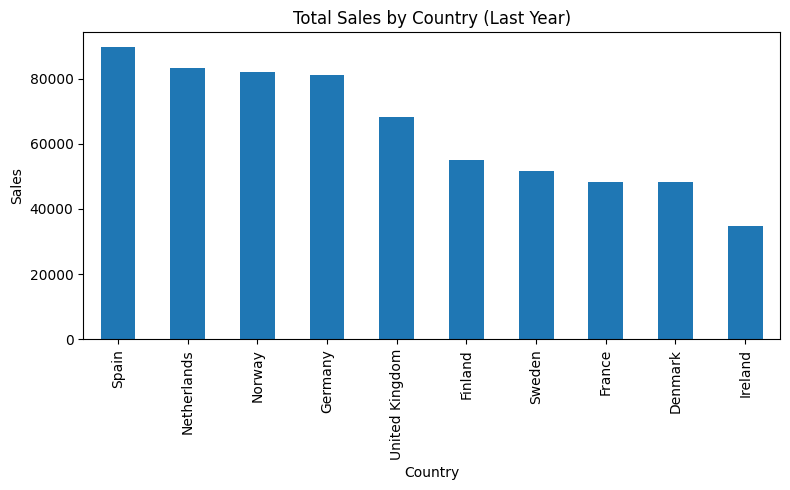

In [4]:
# Bar chart: total sales by country (sum across quarters)
country_totals = rollup.groupby("Country")["TotalSales"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
country_totals.plot(kind="bar")   # default matplotlib styling
plt.title("Total Sales by Country (Last Year)")
plt.ylabel("Sales")
plt.xlabel("Country")
plt.tight_layout()
plt.savefig(os.path.join(OLAP_DIR, "sales_by_country.png"), dpi=150)
plt.show()

# Save data artifacts
rollup.to_csv(os.path.join(OLAP_DIR, "rollup_country_quarter.csv"), index=False)
drilldown_uk.to_csv(os.path.join(OLAP_DIR, "drilldown_uk_monthly.csv"), index=False)
slice_electronics.to_csv(os.path.join(OLAP_DIR, "slice_electronics.csv"), index=False)


# 5. Analysis
The roll-up shows that sales are concentrated in a few countries, which suggests focusing marketing and inventory on those regions. Quarterly totals peak in Q4, indicating a seasonal effect—useful for demand planning and staffing. The UK drill-down reveals month-to-month variability with clear surges that likely align to holidays and promotions; teams can test targeted offers during these periods. The Electronics slice contributes a sizeable share of revenue, implying product depth and price elasticity in that category. The dimensional model (Customer, Product, Time) allowed these questions to be answered with simple joins and groupings, keeping query latency low and logic transparent. While the dataset is programmatically generated in ETL, the queries, schema, and process mirror a realistic retail warehouse and support common BI use cases (geography, seasonality, category contribution). For production, the same model can scale by partitioning the fact table by date and materializing country/quarter summaries for dashboards